In [ ]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
import json
import scipy
import librosa

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def plot_waveform(audio, fs):
    """Plots the waveform of audio in the time domain.

    Parameters:
        audio (numpy.ndarray): audio signal
        fs (int): sampling frequency (Hz) of audio signal

    """
    plt.figure(figsize = (12, 6))
    librosa.display.waveshow(audio, sr=fs, alpha=0.8)
    plt.xlabel("Time")
    plt.ylabel("Amplitude")

In [ ]:
def calc_spec_db(audio, kind='mag'):
    """Calculates the spectrum of an audio signal.

    Parameters:
        audio (numpy.ndarray): audio signal
        kind (str): type of spectrum to calculate
            - 'mag' = magnitude spectrum (real values)
            - 'phs' = phase spectrum (imaginary values)
            - 'com' = complex spectrum (both magnitude and phase)
    Returns:
        spec_db (numpy.ndarray) = the audio spectrum in db scale (re 20 μPa)
    """
    spec = scipy.fft.fft(x=audio)

    if kind.lower() == 'm' or 'mag' or 'magnitude':
        spec_db = 20*np.log10(np.abs(spec))
    elif kind.lower() == 'p' or 'pha' or 'phase':
        spec_db = 20*np.log10(np.imag(spec))
    elif kind.lower() == 'c' or 'com' or 'complex':
        spec_db = 20*np.log10(spec)

    return spec_db

In [ ]:
# Function to plot spectrum
def plot_spec(audio, fs, kind='mag'):
    """Plots the magnitude spectrum of an audio signal/

    Parameters:
        audio (numpy.ndarray): audio signal
        fs (int): sampling frequency (Hz) of audio signal
        kind (str): type of spectrum to calculate
            - 'mag' = magnitude spectrum (real values)
            - 'phs' = phase spectrum (imaginary values)
            - 'com' = complex spectrum (both magnitude and phase)
    """
    # Calculate fft
    spec_db = calc_spec_db(audio, kind=kind)
    f_axis = np.linspace(0, fs, len(spec_db))#, endpoint=False) # create

    # Only take frequencies below nyquist frequency (i.e. fs/2)
    f_axis = f_axis[:int(len(spec_db)/2)]
    spec_db = spec_db[:int(len(spec_db)/2)]

    # Plot
    ax = plt.figure(figsize = (12, 6))
    plt.plot(f_axis, spec_db, alpha=1.0)
    plt.xscale('log')
    plt.xlim(1, fs/2)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude (dB)')
    if fs < 44100:
        plt.xticks([1, 2, 4, 8, 16, 31, 63, 125, 250,500,1000,2000,5000,10000],
                   ["1", "2", "4", "8", "16", "31", "63", "125", "250", "500", "1K", "2K", "5K", "10K"])
    else:
        plt.xticks([1, 2, 4, 8, 16, 31, 63, 125, 250,500,1000,2000,5000,10000, 20000],
                   ["1", "2", "4", "8", "16", "31", "63", "125", "250", "500", "1K", "2K", "5K", "10K", "20k"])

In [ ]:
def calc_stft(audio, fs, n_fft=2048, hop_length=512, dB=True):
    """Calculate the sfort-time-fourier-transform over an audio signal

    Parameters:
        audio (numpy.ndarray): audio signal
        fs (int): sampling frequency (Hz) of audio signal
        n_fft (int): The length (i.e. resolution) of the FFT window (must be power of 2)
        hop_length (int): The number of samples between successive frames
        dB (str):
            - True: Convert to dB scale (aka log scale)
            - False: Do not convert to dB (aka linear scale)

    Returns:
        stft (numpy.ndarray): Short-time Fourier Transform of the audio signal (i.e. frequency domain data)
    """
    # Calculate STFTs (Short-time Fourier transform) over full audio length
    # absolute value to calculate magnitude (drop imag values)
    stft = np.abs(librosa.stft(y=audio, n_fft=n_fft, hop_length=hop_length))

    # Convert to dB (aka log-scale)
    if dB:
        stft = librosa.amplitude_to_db(stft, ref=np.max) # ref - set max to 0 dB

    return stft

In [ ]:
def plot_spectrogram(audio, fs, n_fft=2048, hop_length=512, dB=True, fig_size=(12,6)):
    """Plots audio spectrogram.

    Parameters:
        audio (numpy.ndarray): audio signal
        fs (int): sampling frequency (Hz) of audio signal
        n_fft (int): The length (i.e. resolution) of the FFT window (must be power of 2)
        hop_length (int): The number of samples between successive frames
        dB (str):
            - True: Convert to dB scale (aka log scale)
            - False: Do not convert to dB (aka linear scale)
        fig_size (tuple): Dimensions of figure
    """
    # Calculate STFTs
    stft_db = calc_stft(audio, fs, n_fft=n_fft, hop_length=hop_length, dB=dB)

    plt.figure(figsize=fig_size)
    librosa.display.specshow(data=stft_db, sr=fs, x_axis='time', y_axis='log', cmap='viridis')

    # Put a descriptive title on the plot
    plt.title('Spectrogram')

    # draw a color bar
    plt.colorbar(format='%+02.0f dB')

    # Make the figure layout compact
    plt.tight_layout();

In [ ]:
def calc_mel_spec(audio, fs, n_mfccs=128, n_fft=2048, hop_length=512):
    """calculates the Mel-scaled spectrogram.

    Parameters:
        audio (numpy.ndarray): audio signal
        fs (int): sampling frequency (Hz) of audio signal
        n_mfccs: The number of MFCCs to compute (i.e. dimensionality of mel spectrum)
        n_fft (int): The length (i.e. resolution) of the FFT window (must be power of 2)
        hop_length (int): The number of samples between successive frames

    Returns:
        mel_spec_db (numpy.ndarray): Mel-scaled spectrogram in dB
    """
    # Mel-scaled power spectrogram
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=fs, n_mels=n_mfccs, n_fft=n_fft, hop_length=hop_length)

    # Convert to dB (aka log-scale)
    mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max) # ref - set max to 0 dB

    return mel_spec_db

In [ ]:
def plot_mel_spectrogram_audio(audio, fs, n_mfccs=128, n_fft=2048, hop_length=512, fig_size=(12,6)):
    """Plots the mel-scaled spectrogram from audio signal.

    Parameters:
        audio (numpy.ndarray): audio signal
        fs (int): sampling frequency (Hz) of audio signal
        n_mfccs: The number of MFCCs to compute (i.e. dimensionality of mel spectrum)
        n_fft (int): The length (i.e. resolution) of the FFT window (must be power of 2)
        hop_length (int): The number of samples between successive frames
        fig_size (tuple): Dimensions of figure
    """
    # Calculate mel-spectrogram
    mel_spec_db = calc_mel_spec(audio, fs, n_mfccs=n_mfccs, n_fft=n_fft, hop_length=hop_length)

    # Plot Spectrogram
    plt.figure(figsize=fig_size)
    librosa.display.specshow(data=mel_spec_db, sr=fs, x_axis='time', y_axis='mel', cmap='viridis')

    # Put a descriptive title on the plot
    plt.title('Mel Power Spectrogram')

    # draw a color bar
    plt.colorbar(format='%+02.0f dB')

    # Make the figure layout compact
    plt.tight_layout()

In [ ]:
def plot_mfcc(mfcc, fs, fig_size=(12,6)):
    """Plots the mel-scaled spectrogram from mfccs. This is performing the same task as
    'plot_mel_spectrogram_audio' with just a different input.

    Parameters:
        mfcc (numpy.ndarray): mfccs of an audio signal
        fs (int): sampling frequency (Hz) of audio signal
        fig_size (tuple): Dimensions of figure
    """
    # Plot Spectrogram
    plt.figure(figsize=fig_size)

    # Display the spectrogram on a mel scale
    # sample rate and hop length parameters are used to render the time axis
    # abs on signal for better visualization
    librosa.display.specshow(data=mfcc, sr=fs, x_axis='time', y_axis='linear', cmap='viridis')

    # Put a descriptive title on the plot
    plt.title('MFCCs')

    # draw a color bar
    plt.colorbar(format='%+02.0f dB')

    # Make the figure layout compact
    plt.tight_layout()

# Exploratory Data Analysis (EDA)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path_data = '/content/drive/MyDrive/Colab Notebooks/Music/genres_original/'
genre = 'blues/'
filename = 'blues.00000.wav'

file_path = path_data + genre + filename

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
fs = 22050 # sampling rate for librosa to resample to
audio_ex, fs = librosa.load(path=file_path, sr=fs) # load audio and sampling rate

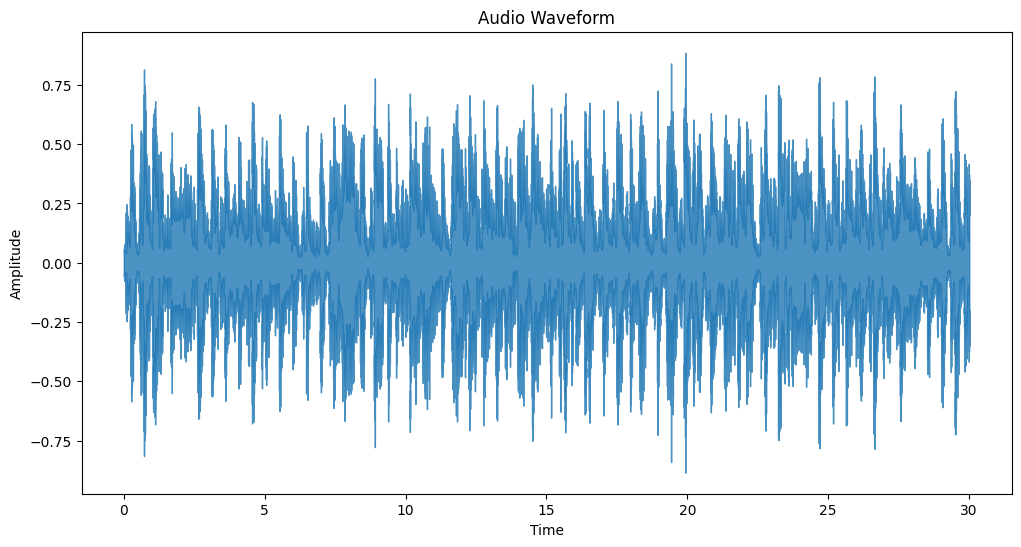

In [ ]:
# Create time axis
plot_waveform(audio_ex, fs);
plt.title('Audio Waveform');

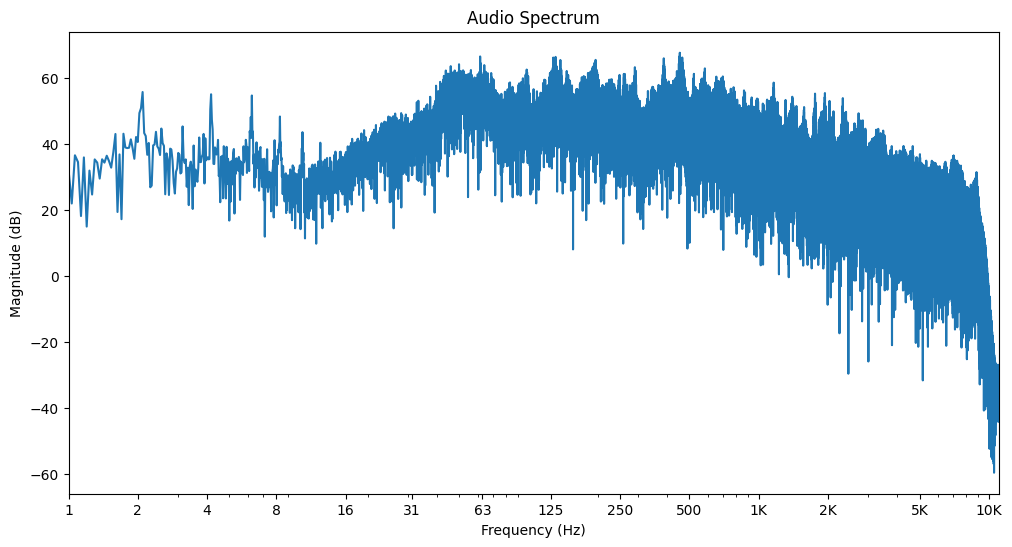

In [ ]:
plot_spec(audio_ex, fs)
plt.title('Audio Spectrum');

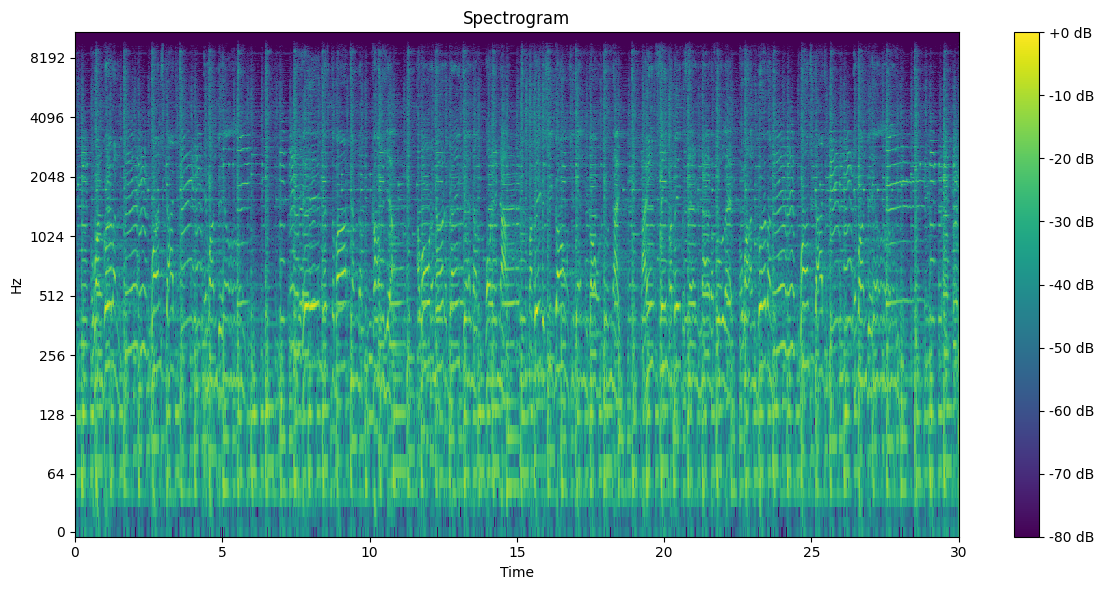

In [ ]:
# Plot Spectrogram
n_fft = 2048 # FFT window size
hop_length = 512 # number audio of frames between STFT columns
dB = True # True for dB scale
plot_spectrogram(audio_ex, fs, n_fft=n_fft, dB=dB, hop_length=hop_length)

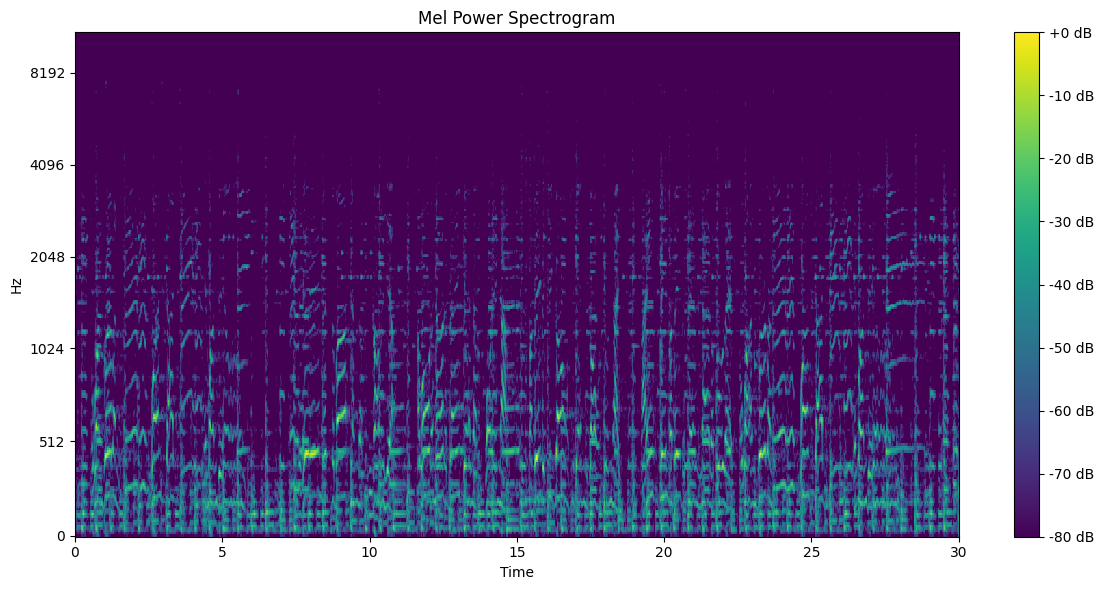

In [ ]:
# Plot Mel-Spectrogram
n_mfccs = 256 # number of mel coeffs
n_fft = 2048 # FFT window size
hop_length = 512 # number audio of frames between STFT columns
plot_mel_spectrogram_audio(audio_ex, fs, n_mfccs=n_mfccs, n_fft=n_fft, hop_length=hop_length, fig_size=(12,6))

# Data Collection & Processing.
The data collection process consists of three steps:

Collect audio data and genres

Convert audio to MFCCs

Save MFCCs and genres to disk

In [ ]:
print(file_path)

/content/drive/MyDrive/Colab Notebooks/Music/genres_original/blues/blues.00000.wav


In [ ]:
# Load the audio files and convert them to MFCCs
# code modified from https://www.youtube.com/watch?v=szyGiObZymo&list=PL-wATfeyAMNrtbkCNsLcpoAyBBRJZVlnf&index=12
def get_mfccs(directory_path, fs=22500, duration=30, n_fft=2048, hop_length=512, n_mfcc=13, num_segments=10):
    """Reads through a directory of audio files and saves a dictionary of MFCCs and genres to a .json file. It also returns
    numpy.ndarrays for MFCCs, genre name, and genre number for each segment of audio signal.

    Parameters:
        audio (numpy.ndarray): audio signal
        fs (int): sampling frequency (Hz) of audio signal
        duration (int): duration of audio signal (sec)
        n_fft (int): The length (i.e. resolution) of the FFT window (must be power of 2)
        hop_length (int): The number of samples between successive frames
        n_mfccs: The number of MFCCs to compute (i.e. dimensionality of mel spectrum)
        num_segments (int): number of segments for the audio signal to be broken up into

    Returns:
        "mfcc" (numpy.ndarray): MFCC vectors for each segment
        "genre_name" (numpy.ndarray): name of the genre for each segment (i.e. blues, classical, etc.)
        "genre_num" (numpy.ndarray): number value of the genre for each segment (i.e. 0, 1, 2, etc.)
    """
    data = {
        "genre_name": [],   # name of the genre (i.e. blues, classical, etc.)
        "genre_num": [],    # number value of the genre (i.e. 0, 1, 2, etc.)
        "mfcc": []          # the mfcc vectors
    }

    # Calculate the number of samples per segment and the
    samples_per_track = fs * duration # Calculate the number of samples for desired "duration" of track
    samps_per_segment = int(samples_per_track/num_segments) # number of samples per segment
    mfccs_per_segment = math.ceil(samps_per_segment/hop_length) # number of MFCC vectors per segment

    # Loop through all folders & files in the data directory
        # path_current: Path to the current folder (start at outermost folder, then 'walk' in)
        # folder_names: List of names of all folders within the current folder
        # file_names: names List of names of all files within the current folder
        # i: index of current iteration
    print("MFCC collection started!")
    print("========================")
    for i, (path_current, folder_names, file_names) in enumerate(os.walk(directory_path)):

        # Check to make sure that the current folder is not the parent folder
        if path_current is not directory_path:

            # Save
            path_list = path_current.split('/') # split the path into a list
            genre_current = path_list[-1] # select last item in path list (name of folder = genre)

            # Loop through files for each genre (sub-directory)
            for file in file_names:

                # Load audio data
                file_path = os.path.join(path_current, file).replace(os.sep, '/') # create audio file path

                # try/except to skip a few files that create issues
                try:
                    # Load audio data and sampling frequency
                    audio, fs = librosa.load(file_path, sr=fs) # audio in samples, sampling rate

                    # Loop through audio file for specified number of segments to calculate MFCCs
                    for seg in range(num_segments):

                        # Calculate the samples to bound each segment
                        start_sample = seg * samps_per_segment # segment starting sample
                        end_sample = start_sample + samps_per_segment # segment ending sample

                        # Calculate segment MFCC
                        mfcc = librosa.feature.mfcc(y=audio[start_sample:end_sample],    # audio signal
                                                    sr=fs,                               # sampling rate (Hz)
                                                    n_fft=n_fft,                         # fft window size
                                                    hop_length=hop_length,               # hop size
                                                    n_mfcc=n_mfcc)                       # number of mfccs to compute

                        mfcc = mfcc.T # transpose for appropriate list appending

                        # Confirm correct number of mfccs for each segment, then append
                        if len(mfcc) == mfccs_per_segment:
                            data["genre_name"].append(genre_current) # append current genre to list of genres
                            data["genre_num"].append(i-1) # append current genre to list of genres
                            data["mfcc"].append(mfcc.tolist()) # append current mfcc to list of mfccs
                except:
                    continue

            # Print update status
            print(f"Collected MFCCs for {genre_current.title()}!")

    with open('/content/drive/MyDrive/Colab Notebooks/Music/data.json', "w") as filepath:
        print("========================")
        print("Saving data to disk...")
        json.dump(data, filepath, indent=4)
        print("Saving complete!")
        print("========================")

    # option to return MFCCs and genres
    return np.array(data["mfcc"]), np.array(data["genre_name"]), np.array(data["genre_num"])


# Collect and Compute MFCCs

In [ ]:
%%time
# Set up the parameters for the MFCC conversion
n_mfcc = 13
n_fft = 2048
hop_length = 512
num_segments = 10 # split teack into 10 segments (3 sec each)
track_duration = 30 # Length of tracks (sec)

directory_path = '/content/drive/MyDrive/Colab Notebooks/Music/genres_original/'
mfccs, genres, genre_nums = get_mfccs(directory_path,
                          fs=fs,
                          duration=track_duration,
                          n_fft=n_fft,
                          hop_length=hop_length,
                          n_mfcc=n_mfcc,
                          num_segments=num_segments)

MFCC collection started!
Collected MFCCs for Reggae!
Collected MFCCs for Classical!
Collected MFCCs for Pop!
Collected MFCCs for Blues!
Collected MFCCs for Rock!
Collected MFCCs for Disco!
Collected MFCCs for Country!
Collected MFCCs for Metal!


<ipython-input-28-dc8f0adb4324>:57: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, fs = librosa.load(file_path, sr=fs) # audio in samples, sampling rate
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Collected MFCCs for Jazz!
Collected MFCCs for Hiphop!
Saving data to disk...
Saving complete!
CPU times: user 2min 11s, sys: 1min 18s, total: 3min 29s
Wall time: 2min 31s


In [ ]:
# Review mfccs and genres for the correct shape
print(f"MFCCs: {mfccs.shape}")
print(f"genres: {genres.shape}")

MFCCs: (9986, 130, 13)
genres: (9986,)


In [ ]:
# Map target genre to number
genre_map = dict(zip(sorted(set(genres)), np.arange(0, 10)))
genres_num = np.array(pd.Series(genres).map(genre_map))
list(zip(genres_num, genres)) # view mapped target

[(8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 'reggae'),
 (8, 're

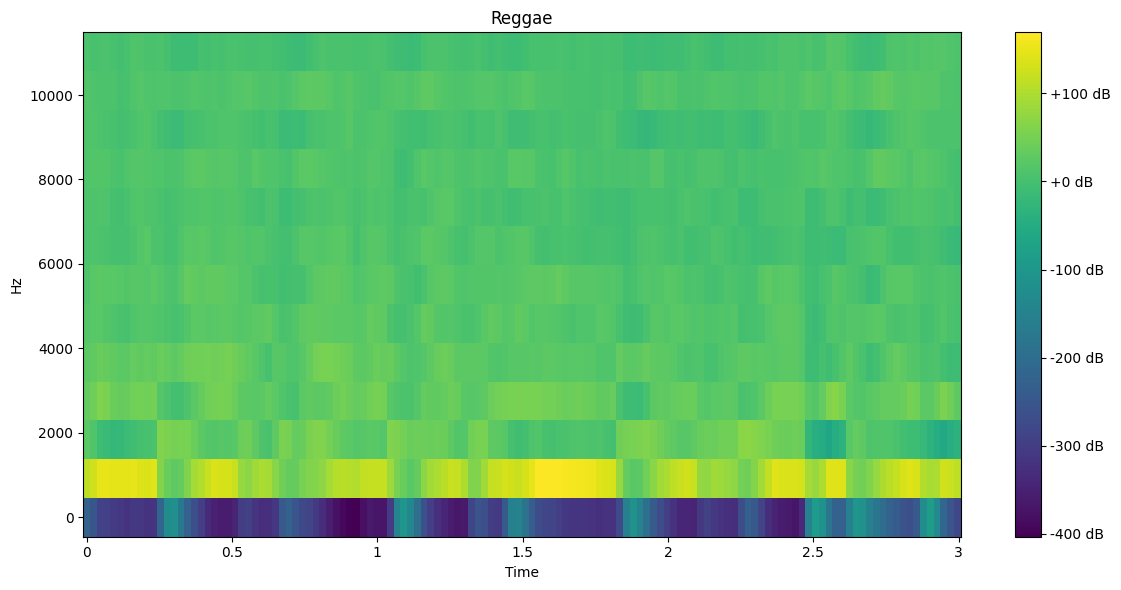

In [ ]:
# Plot an MFCC example
idx = 0
plot_mfcc(mfccs[idx].T, fs)
plt.title(f"{genres[idx].title()}");

# Modelling

# Imports

In [ ]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import librosa

# Sklean
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# TensorFlow
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load Data

In [ ]:
# Load in audio data
filepath = '/content/drive/MyDrive/Colab Notebooks/Music/data.json'
with open(filepath, "r") as fp:
    data = json.load(fp)

In [ ]:
def plot_mfcc(mfcc, fs, fig_size=(12,6)):
    """Plots the mel-scaled spectrogram from mfccs. This is performing the same task as
    'plot_mel_spectrogram_audio' with just a different input.

    Parameters:
        mfcc (numpy.ndarray): mfccs of an audio signal
        fs (int): sampling frequency (Hz) of audio signal
        fig_size (tuple): Dimensions of figure
    """
    # Plot Spectrogram
    plt.figure(figsize=fig_size)

    # Display the spectrogram on a mel scale
    # sample rate and hop length parameters are used to render the time axis
    # abs on signal for better visualization
    librosa.display.specshow(data=mfcc, sr=fs, x_axis='time', y_axis='linear', cmap='viridis')

    # Put a descriptive title on the plot
    plt.title('MFCCs')

    # draw a color bar
    plt.colorbar(format='%+02.0f dB')

    # Make the figure layout compact
    plt.tight_layout()

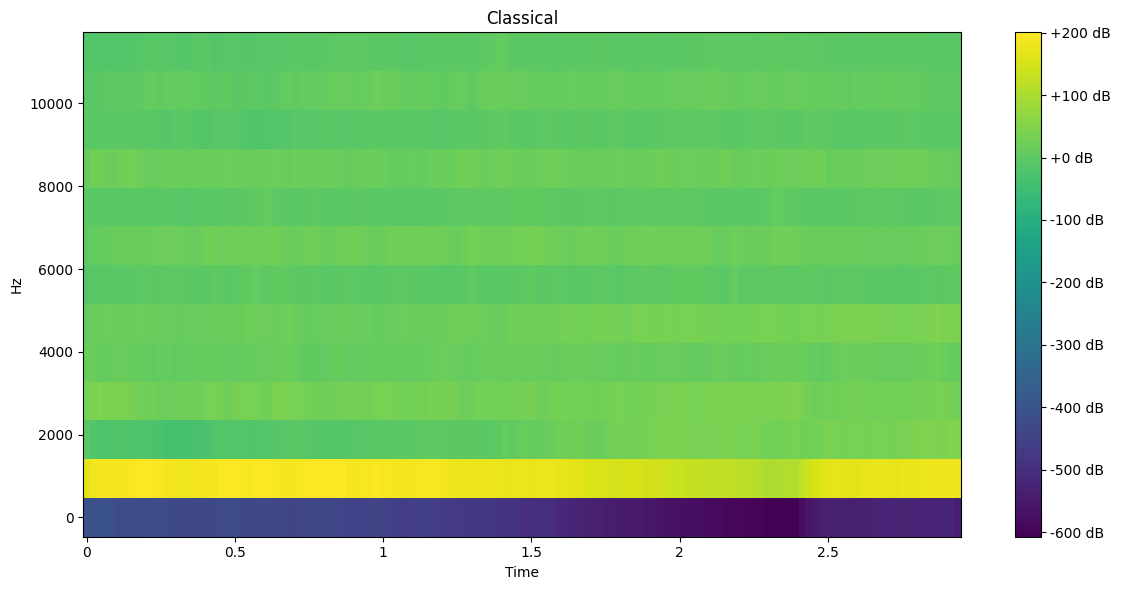

In [ ]:
# Plot MFCC example to ensure data was imported properly
idx = 1000
fs = 22500
plot_mfcc(np.array(data["mfcc"])[idx].T, fs)
plt.title(f"{np.array(data['genre_name'])[idx].title()}");

# Modeling

In [ ]:
# Define X nd y
X = np.array(data["mfcc"])
y = np.array(data["genre_num"])

In [ ]:
# Train-validation-test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

# shape = (# samples, time-bins (x), num MFCCs (y))
print(f"X training data shape: {X_train.shape}, y training data shape: {y_train.shape}")
print(f"X validation data shape: {X_val.shape}, y validation data shape: {y_val.shape}")

X training data shape: (4893, 130, 13), y training data shape: (4893,)
X validation data shape: (2097, 130, 13), y validation data shape: (2097,)


In [ ]:
def plot_history(hist):
    """Plots the accuracy and loss for a model over the course of all epochs

    Parameters:
        hist (keras history object): The recorded history of model.fit() to be plotted
    """
    fig, axs = plt.subplots(2, 1, figsize=(8,7))
    fig.tight_layout(pad=2)

    # Accuracy subplot
    axs[0].plot(hist.history["acc"], c='navy', label="Training Accuracy")
    axs[0].plot(hist.history["val_acc"], c='orange', label="Validation Accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy")

    # Error subplot
    axs[1].plot(hist.history["loss"], c='navy', label="Training Loss")
    axs[1].plot(hist.history["val_loss"], c='orange', label="Validation Loss")
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epochs")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Loss")

    plt.show()

# Convolutional Neural Network (Without Regularization)

In [ ]:
# Add additional dimension for CNN
X_train_cnn = X_train[..., np.newaxis]
X_val_cnn = X_val[..., np.newaxis]
X_test_cnn = X_test[..., np.newaxis]

input_shape = X_train_cnn.shape[1:4]
X_train_cnn.shape # shape = (# samples, time-bins (x), num MFCCs (y), "channel" (like an image))

(4893, 130, 13, 1)

In [ ]:
# Convolutional Neural Network - Original

# Instantiate sequential model
model_cnn1 = Sequential()

# Create a convolution block
model_cnn1.add(Conv2D(32, 3, activation='relu', input_shape=input_shape)) # first hidden conv layer
model_cnn1.add(MaxPooling2D(3, strides=(2,2), padding='same')) # MaxPool the results

# Add another conv block
model_cnn1.add(Conv2D(64, 3, activation='relu'))
model_cnn1.add(MaxPooling2D(3, strides=(2,2), padding='same'))

# Add another conv block
model_cnn1.add(Conv2D(64, 2, activation='relu'))
model_cnn1.add(MaxPooling2D(2, strides=(2,2), padding='same'))

# Flatten output to send through dense layers
model_cnn1.add(Flatten())
model_cnn1.add(Dense(64, activation='relu'))

# output to 10 classes for predictions
model_cnn1.add(Dense(10, activation='softmax')) # Softmax activation for multi-class classification

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model_cnn1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 11, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 6, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 62, 4, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 31, 2, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 30, 1, 64)           │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 15, 1, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 960)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          61,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 97,418 (380.54 KB)

 Trainable params: 97,418 (380.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_cnn1.compile(
    optimizer=Adam(learning_rate=0.0001), # can also use 'adam'
    loss='sparse_categorical_crossentropy', # loss for multi-class classification
    metrics=['acc']
)

In [ ]:
%%time
# Train the model
hist_cnn1 = model_cnn1.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    batch_size=64,
    epochs=250,
    verbose=1
)

Epoch 1/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - acc: 0.1938 - loss: 4.2269 - val_acc: 0.3247 - val_loss: 1.9879
Epoch 2/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.3835 - loss: 1.8035 - val_acc: 0.4001 - val_loss: 1.7569
Epoch 3/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.4207 - loss: 1.6159 - val_acc: 0.4192 - val_loss: 1.6509
Epoch 4/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.4752 - loss: 1.4768 - val_acc: 0.4416 - val_loss: 1.5936
Epoch 5/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.5032 - loss: 1.3991 - val_acc: 0.4769 - val_loss: 1.4918
Epoch 6/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.5335 - loss: 1.3060 - val_acc: 0.4893 - val_loss: 1.4376
Epoch 7/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.5692 - loss: 1.2198 - val_acc: 0.5012 - val_loss: 1.4227
Epoch 8/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.5790 - loss: 1.1837 - val_acc: 0.5098 - val_loss: 1.3810
Epoch 9/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.597

In [ ]:
loss_cnn1, acc_cnn1 = model_cnn1.evaluate(X_test_cnn, y_test)
print(f"Test Loss: {loss_cnn1}")
print(f"Test Accuracy: {acc_cnn1}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.6783 - loss: 2.1659
Test Loss: 2.136211633682251
Test Accuracy: 0.6822429895401001


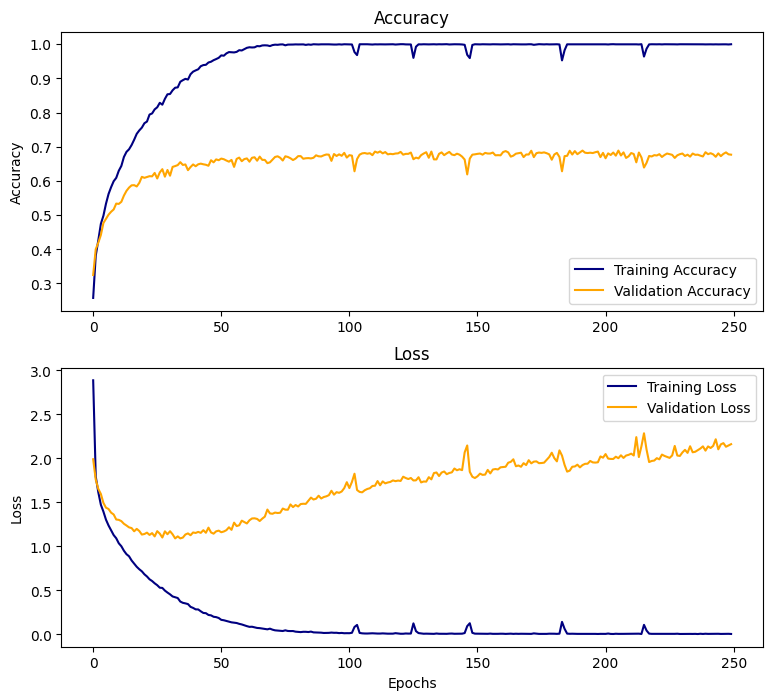

In [ ]:
plot_history(hist_cnn1)

# Convolutional Neural Network (With Regularization)

In [ ]:
# Convolutional Neural Network - BEST

# Instantiate sequential model
model_cnn2 = Sequential()

# Create a convolution block
model_cnn2.add(Conv2D(32, 3, activation='relu', input_shape=input_shape)) # first hidden conv layer
model_cnn2.add(BatchNormalization())
model_cnn2.add(MaxPooling2D(3, strides=(2,2), padding='same')) # MaxPool the results
model_cnn2.add(Dropout(0.2))

# Add another conv block
model_cnn2.add(Conv2D(64, 3, activation='relu'))
model_cnn2.add(BatchNormalization())
model_cnn2.add(MaxPooling2D(3, strides=(2,2), padding='same'))
model_cnn2.add(Dropout(0.1))

# Add another conv block
model_cnn2.add(Conv2D(64, 2, activation='relu'))
model_cnn2.add(BatchNormalization())
model_cnn2.add(MaxPooling2D(2, strides=(2,2), padding='same'))
model_cnn2.add(Dropout(0.1))

# Flatten output to send through dense layers
model_cnn2.add(Flatten())
model_cnn2.add(Dense(128, activation='relu'))
model_cnn2.add(Dropout(0.5))

# output to 10 classes for predictions
model_cnn2.add(Dense(10, activation='softmax')) # Softmax activation for multi-class classification

In [ ]:
model_cnn2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 128, 11, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 11, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 6, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 6, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 62, 4, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 62, 4, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 31, 2, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 31, 2, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 30, 1, 64)           │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 30, 1, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 15, 1, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 15, 1, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 960)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         123,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 160,202 (625.79 KB)

 Trainable params: 159,882 (624.54 KB)

 Non-trainable params: 320 (1.25 KB)

In [ ]:
model_cnn2.compile(
    optimizer=Adam(learning_rate=0.0001), # can also use 'adam'
    loss='sparse_categorical_crossentropy', # loss for multi-class classification
    metrics=['acc']
)

In [ ]:
# Create an early stopping callback

es_cnn2 = EarlyStopping(
    monitor='val_loss',        # Monitor validation loss
    patience=20,               # Number of epochs with no improvement before stopping
    min_delta=0.001,           # Minimum change in validation loss to count as improvement
    restore_best_weights=True  # Restore the best weights after training stops
)


In [ ]:
%%time
# Train the model
hist_cnn2 = model_cnn2.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    batch_size=64,
    epochs=250,
    verbose=1
#     callbacks=[es_cnn2]
)

Epoch 1/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 14s 103ms/step - acc: 0.1249 - loss: 3.4212 - val_acc: 0.2413 - val_loss: 2.1480
Epoch 2/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.2545 - loss: 2.4293 - val_acc: 0.3085 - val_loss: 1.8539
Epoch 3/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.3158 - loss: 2.1363 - val_acc: 0.3538 - val_loss: 1.7959
Epoch 4/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.3269 - loss: 2.0065 - val_acc: 0.3796 - val_loss: 1.8234
Epoch 5/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.3610 - loss: 1.8647 - val_acc: 0.3939 - val_loss: 1.8788
Epoch 6/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.3800 - loss: 1.7447 - val_acc: 0.4049 - val_loss: 1.9148
Epoch 7/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.3901 - loss: 1.6925 - val_acc: 0.4230 - val_loss: 1.9118
Epoch 8/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.4194 - loss: 1.6202 - val_acc: 0.4268 - val_loss: 1.9286
Epoch 9/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.4

In [ ]:
loss_cnn2, acc_cnn2 = model_cnn2.evaluate(X_test_cnn, y_test)
print(f"Test Loss: {loss_cnn2}")
print(f"Test Accuracy: {acc_cnn2}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.7911 - loss: 0.8850
Test Loss: 0.8148672580718994
Test Accuracy: 0.8004005551338196


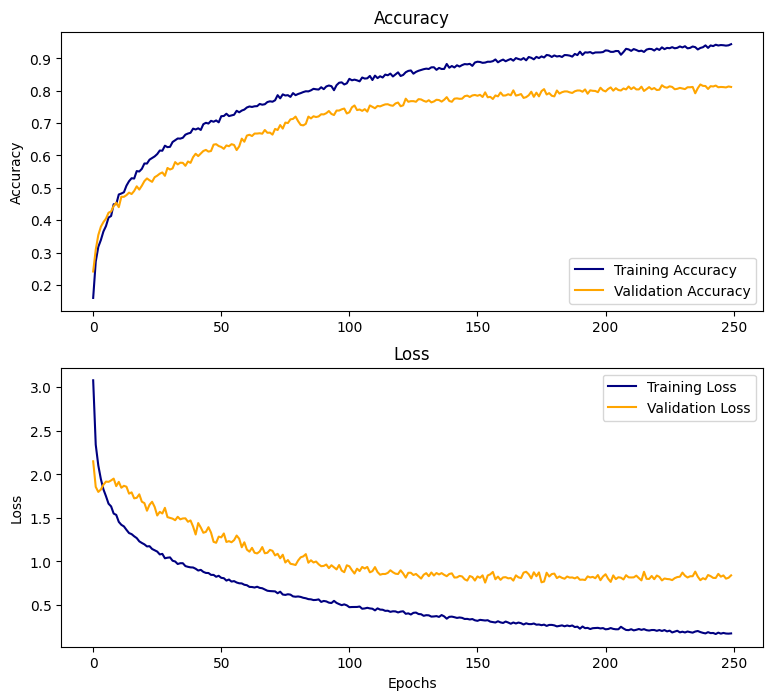

In [ ]:
plot_history(hist_cnn2)

# Convolutional Neural Network (With Regularization and Data Augmentation)

In [ ]:
# Convolutional Neural Network - BEST

# Instantiate sequential model
model_cnn3 = Sequential()

# Create a convolution block
model_cnn3.add(Conv2D(32, 3, activation='relu', input_shape=input_shape)) # first hidden conv layer
model_cnn3.add(BatchNormalization())
model_cnn3.add(MaxPooling2D(3, strides=(2,2), padding='same')) # MaxPool the results
model_cnn3.add(Dropout(0.2))

# Add another conv block
model_cnn3.add(Conv2D(64, 3, activation='relu'))
model_cnn3.add(BatchNormalization())
model_cnn3.add(MaxPooling2D(3, strides=(2,2), padding='same'))
model_cnn3.add(Dropout(0.1))

# Add another conv block
model_cnn3.add(Conv2D(64, 2, activation='relu'))
model_cnn3.add(BatchNormalization())
model_cnn3.add(MaxPooling2D(2, strides=(2,2), padding='same'))
model_cnn3.add(Dropout(0.1))

# Flatten output to send through dense layers
model_cnn3.add(Flatten())
model_cnn3.add(Dense(128, activation='relu'))
model_cnn3.add(Dropout(0.5))

# output to 10 classes for predictions
model_cnn3.add(Dense(10, activation='softmax')) # Softmax activation for multi-class classification

In [ ]:

model_cnn3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 128, 11, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128, 11, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 64, 6, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64, 6, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 62, 4, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 62, 4, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 31, 2, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 31, 2, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 30, 1, 64)           │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 30, 1, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 15, 1, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 15, 1, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 960)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         123,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 160,202 (625.79 KB)

 Trainable params: 159,882 (624.54 KB)

 Non-trainable params: 320 (1.25 KB)

In [ ]:
model_cnn3.compile(
    optimizer=Adam(learning_rate=0.0001), # can also use 'adam'
    loss='sparse_categorical_crossentropy', # loss for multi-class classification
    metrics=['acc']
)

In [ ]:
# Datagen
datagen = ImageDataGenerator()

In [ ]:
# Create an early stopping callback
es_cnn3 = EarlyStopping(
    monitor='val_loss',        # Monitor validation loss
    patience=20,               # Stop after 20 epochs without improvement
    min_delta=0.001,           # Minimum change in validation loss to qualify as improvement
    restore_best_weights=True  # Restore the best weights when stopping
)


In [ ]:
%%time
# Train the model
hist_cnn3 = model_cnn3.fit(
    datagen.flow(X_train_cnn, y_train),
    validation_data=(X_val_cnn, y_val),
    batch_size=64,
    epochs=400,
    verbose=1,
    callbacks=[es_cnn3]  # Add the early stopping callback here
)



Epoch 1/400


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


153/153 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - acc: 0.1304 - loss: 3.7371 - val_acc: 0.3057 - val_loss: 2.0960
Epoch 2/400
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.2611 - loss: 2.5252 - val_acc: 0.3486 - val_loss: 2.1440
Epoch 3/400
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.3315 - loss: 2.0491 - val_acc: 0.3829 - val_loss: 2.0856
Epoch 4/400
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.3483 - loss: 1.9346 - val_acc: 0.3977 - val_loss: 2.2171
Epoch 5/400
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.3827 - loss: 1.7558 - val_acc: 0.4058 - val_loss: 2.2389
Epoch 6/400
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.4091 - loss: 1.6649 - val_acc: 0.4182 - val_loss: 2.1703
Epoch 7/400
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.4201 - loss: 1.6468 - val_acc: 0.4206 - val_loss: 2.2827
Epoch 8/400
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.4542 - loss: 1.5699 - val_acc: 0.4130 - val_loss: 2.4397
Epoch 9/400
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc

In [ ]:
loss_cnn3, acc_cnn3 = model_cnn3.evaluate(X_test_cnn, y_test)
print(f"Test Loss: {loss_cnn3}")
print(f"Test Accuracy: {acc_cnn3}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.7619 - loss: 0.8109
Test Loss: 0.7892538905143738
Test Accuracy: 0.7633511424064636


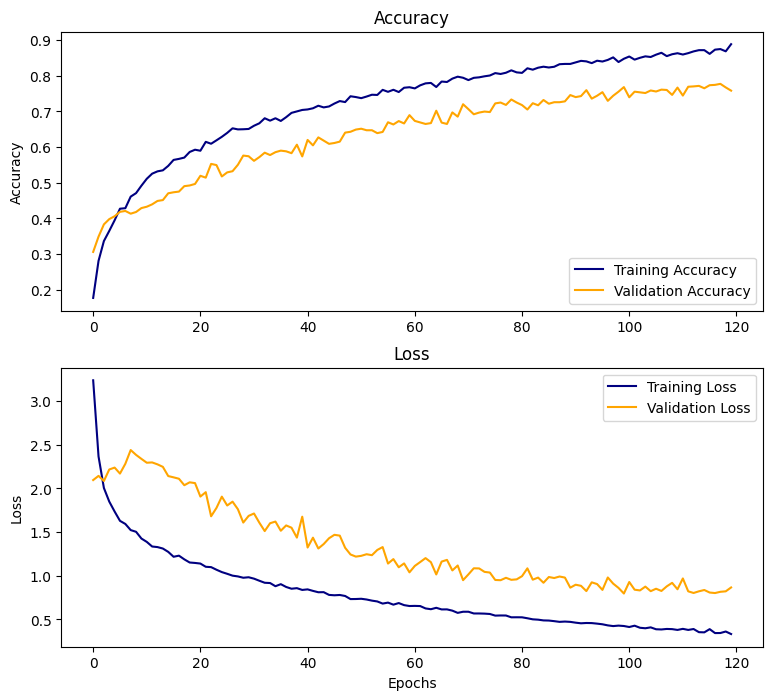

In [ ]:
plot_history(hist_cnn3)

In [ ]:
# Save Models

In [ ]:

model_cnn1.save('/content/drive/MyDrive/Colab Notebooks/Music/model_cnn1.h5')
model_cnn2.save('/content/drive/MyDrive/Colab Notebooks/Music/model_cnn2.h5')
model_cnn3.save('/content/drive/MyDrive/Colab Notebooks/Music/model_cnn3.h5')

In [ ]:
# Save models in the recommended Keras format
model_cnn1.save('/content/drive/MyDrive/Colab Notebooks/Music/model_cnn1.keras')
model_cnn2.save('/content/drive/MyDrive/Colab Notebooks/Music/model_cnn2.keras')
model_cnn3.save('/content/drive/MyDrive/Colab Notebooks/Music/model_cnn3.keras')


# Make Predictions

In [ ]:
def make_prediction(model, X):
    """Makes predictions given a keras model and a set of data.

    Parameters:
        model (keras model): The model to use to make predictions
        X (np.sdarray): Testing data to be fed into the model to make predictions with.

    Returns:
        preds_num (list): List of genre predictions (number format, 0-9)
        preds_name (list): List of genre predictions (str format)
    """
    genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
    preds_num = []
    preds_name = []

    for X_current in X:
        X_current = X_current[np.newaxis, ...]
        pred = model.predict(X_current)
        pred = np.argmax(pred, axis=1) # predicted index
        preds_num.append(pred[0])
        preds_name.append(genres[pred[0]])

    return preds_num, preds_name

In [ ]:
%%time
# Make predictions - Takes ~10 min to run
preds_num, preds_name = make_prediction(model_cnn3, X_test_cnn)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

In [ ]:
# Check the first 10 predictions
for i in range(10):
    print(f"Input {i+1}: Predicted Genre = {preds_name[i]}, True Genre = {genres[y_test[i]]}")

Input 1: Predicted Genre = pop, True Genre = pop
Input 2: Predicted Genre = blues, True Genre = rock
Input 3: Predicted Genre = reggae, True Genre = reggae
Input 4: Predicted Genre = rock, True Genre = jazz
Input 5: Predicted Genre = reggae, True Genre = reggae
Input 6: Predicted Genre = metal, True Genre = hiphop
Input 7: Predicted Genre = hiphop, True Genre = pop
Input 8: Predicted Genre = hiphop, True Genre = hiphop
Input 9: Predicted Genre = hiphop, True Genre = hiphop
Input 10: Predicted Genre = pop, True Genre = pop


In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, preds_num)

In [ ]:
# Plot confusion matrix for review
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
fig, ax = plt.subplots(figsize=(8,8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genres)
disp.plot(ax=ax, cmap = 'Purples', xticks_rotation='vertical')
plt.title('Genre Classification (3 second clips)');